In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
# Using pip install to install those package


# US

### Read Data

In [ ]:
# Interest Rate
fed_funds = pd.read_csv('./Data/US/FEDFUNDS.csv')
# Indices Data
sp500 = pd.read_csv('./Data/US/S&P 500 Historical Price Data.csv')
# Inflation Data
us_inflation = pd.read_csv('./Data/US/US Inflation Rate.csv')
# GDP Growth Rate
us_gdp = pd.read_csv('./Data/US/USGDP.csv')
# CCI Data
us_cci = pd.read_csv('./Data/US/US CCI.csv')

In [ ]:
fed_funds['observation_date'] = pd.to_datetime(fed_funds['observation_date'], format='%d/%m/%Y')

us_inflation['Date'] = pd.to_datetime(us_inflation['Date'], format='%b-%y')

sp500['Date'] = pd.to_datetime(sp500['Date'])

us_gdp['Date'] = pd.to_datetime(us_gdp['Date'], format='%d/%m/%Y')

us_cci['Release Date'] = pd.to_datetime(us_cci['Release Date'], format='%d/%m/%Y')


### Merge Data

In [ ]:
# Convert all to monthly data, using the average or last value
sp500 = sp500.set_index('Date').resample('M').last()
fed_funds = fed_funds.set_index('observation_date').resample('M').last()
us_inflation = us_inflation.set_index('Date').resample('M').last()
us_gdp = us_gdp.set_index('Date').resample('M').last()
us_cci = us_cci.set_index('Release Date').resample('M').last()

In [ ]:
# Merge datasets on the date index
df = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
df.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']

data = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
data.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']

origi_data = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
origi_data.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']

df['SP500_Price'] = df['SP500_Price'].replace('[\$,]', '', regex=True)
df['SP500_Price'] = pd.to_numeric(df['SP500_Price'], errors='coerce')

data['SP500_Price'] = data['SP500_Price'].replace('[\$,]', '', regex=True)
data['SP500_Price'] = pd.to_numeric(data['SP500_Price'], errors='coerce')

origi_data['SP500_Price'] = data['SP500_Price'].replace('[\$,]', '', regex=True)
origi_data['SP500_Price'] = pd.to_numeric(data['SP500_Price'], errors='coerce')




### Data Cleaning

In [ ]:
# Nomarlise the data
scaler = MinMaxScaler()
df['FEDFUNDS_adj'] = scaler.fit_transform(df[['FEDFUNDS']])
df['SP500_Price_adj'] = scaler.fit_transform(df[['SP500_Price']])
df['US_Inflation_adj'] = scaler.fit_transform(df[['US_Inflation']])
df['GDP_growth_adj'] = scaler.fit_transform(df[['GDP_growth']])
df['CCI_Rate_adj'] = scaler.fit_transform(df[['CCI_Rate']])

df.dropna(inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
def plot_and_save(x, y1, y2, y1_label, y2_label, y1_color, y2_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    ax.grid(True)
    
    ax.set_xlabel('Date')
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/US/' + filename)
    plt.close(fig)

# SP500_Price 和 FEDFUNDS
plot_and_save(df.index, df['SP500_Price'], df['FEDFUNDS'], 'SP500 Price', 'Fed Funds Rate', 'b', 'g', 'sp500_fedfunds.png')

# SP500_Price 和 US_Inflation
plot_and_save(df.index, df['SP500_Price'], df['US_Inflation'], 'SP500 Price', 'US Inflation Rate', 'b', 'r', 'sp500_inflation.png')

# SP500_Price 和 GDP growth
plot_and_save(df.index, df['SP500_Price'], df['GDP_growth'], 'SP500 Price', 'GDP Growth', 'b', 'c', 'sp500_gdp.png')

# SP500_Price 和 CCI Rate
plot_and_save(df.index, df['SP500_Price'], df['CCI_Rate'], 'SP500 Price', 'CCI Rate', 'b', 'm', 'sp500_cci.png')


In [ ]:
data['FEDFUNDS_adj'] = scaler.fit_transform(data[['FEDFUNDS']])
data['SP500_Price_adj'] = scaler.fit_transform(data[['SP500_Price']])
data['US_Inflation_adj'] = scaler.fit_transform(data[['US_Inflation']])
data['GDP_growth_adj'] = scaler.fit_transform(data[['GDP_growth']])
data['CCI_Rate_adj'] = scaler.fit_transform(data[['CCI_Rate']])

### Regression Analysis

#### Regression

In [ ]:
X = df[['FEDFUNDS_adj', 'US_Inflation_adj', 'GDP_growth_adj', 'CCI_Rate_adj']]
# X = df[['FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['SP500_Price_adj']
# y = df['SP500_Price']

X.dropna(inplace=True)
y = y.loc[X.index]

model = sm.OLS(y, X).fit()
print(model.summary())

# Plot partial regression plots
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

with open('./Results/regression_summary_' + 'FEDFUNDS, US_Inflation, GDP growth, CCI Rate.txt', 'w') as file:
    file.write(model.summary().as_text())

In [ ]:
# X = df[['FEDFUNDS']]
# # X = df[['FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']]
# X = sm.add_constant(X)  # Adds a constant term to the predictor
# y = df['SP500_Price']
# # y = df['SP500_Price']

# X.dropna(inplace=True)
# y = y.loc[X.index]

# model = sm.OLS(y, X).fit()
# print(model.summary())

# # Plot partial regression plots
# fig = plt.figure(figsize=(12, 8))
# fig = sm.graphics.plot_partregress_grid(model, fig=fig)

# with open('./Results/regression_summary_' + 'FEDFUNDS.txt', 'w') as file:
#     file.write(model.summary().as_text())

#### Laggin Effect

In [ ]:
# Define the range of lags for each variable
lag_ranges = {
    'FEDFUNDS': range(-6, 13),
    'US_Inflation': range(-6, 13),
    'CCI_Rate': range(-6, 13),
    'GDP_Growth': range(-6, 13)
}

def fill_missing_with_sampling(df, column, lag, date_range):
    if lag < 0:
        fill_dates = pd.date_range(start=date_range[1] + pd.DateOffset(months=1), periods=-lag, freq='M')
        
        # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[lag:] = fill_values
    
    elif lag > 0:
        fill_dates = pd.date_range(end=date_range[0] - pd.DateOffset(months=1), periods=lag, freq='M')
        
                # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[:lag] = fill_values
    else:
        return df[column]
    
    return filled_series

# Initialize variables to keep track of the best model
best_r_squared = -np.inf
best_model = None
best_lags = None

date_range = [pd.to_datetime('31/01/2015', format='%d/%m/%Y'), pd.to_datetime('31/12/2021', format='%d/%m/%Y')]

In [ ]:
# Iterate over all combinations of lags
for f_lag in lag_ranges['FEDFUNDS']:
    for i_lag in lag_ranges['US_Inflation']:
        for c_lag in lag_ranges['CCI_Rate']:
            for g_lag in lag_ranges['GDP_Growth']:
                # Create lagged DataFrame using fill_missing_with_sampling
                df_lagged = pd.DataFrame({
                    'FEDFUNDS_lag': fill_missing_with_sampling(df, 'FEDFUNDS_adj', f_lag, date_range),
                    'US_Inflation_lag': fill_missing_with_sampling(df, 'US_Inflation_adj', i_lag, date_range),
                    'CCI_Rate_lag': fill_missing_with_sampling(df, 'CCI_Rate_adj', c_lag, date_range),
                    'GDP_Growth_lag': fill_missing_with_sampling(df, 'GDP_growth_adj', g_lag, date_range),
                    'SP500_Price_adj': df['SP500_Price_adj']
                })

                # Define predictors and response
                X = df_lagged[['FEDFUNDS_lag', 'US_Inflation_lag', 'CCI_Rate_lag', 'GDP_Growth_lag']]
                y = df_lagged['SP500_Price_adj']
                X = sm.add_constant(X)  # Adds a constant term to the predictors

                # Fit model
                model = sm.OLS(y, X).fit()

                # Check if this model is the best so far
                if model.rsquared > best_r_squared:
                    best_r_squared = model.rsquared
                    best_model = model
                    best_lags = (f_lag, i_lag, c_lag, g_lag)

# Output the best model results
print("Best R-squared:", best_r_squared)
print("Best Lags: FEDFUNDS_lag={}, US_Inflation_lag={}, CCI_Rate_lag={}, GDP_Growth_lag={}".format(*best_lags))
with open('./Results/lags/US/regression_summary_bestfit.txt', 'w') as file:
    file.write(best_model.summary().as_text())

In [ ]:
def fill_missing_with_sampling_special(df, column, lag, date_range):
    if lag < 0:
        df_copy = origi_data.loc[df.index]
        
        fill_dates = pd.date_range(start=date_range[1] + pd.DateOffset(months=1), periods=-lag, freq='M')
        
        # Fetch fill values and adjust them using the same scaler
        fill_values = origi_data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df_copy[column].shift(lag)
        
        filled_series[lag:] = fill_values
    
    elif lag > 0:
        
        df_copy = origi_data.loc[df.index]
        
        fill_dates = pd.date_range(end=date_range[0] - pd.DateOffset(months=1), periods=lag, freq='M')
        
                # Fetch fill values and adjust them using the same scaler
        fill_values = origi_data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df_copy[column].shift(lag)
        
        filled_series[:lag] = fill_values
    else:
        return df[column]
    
    return filled_series

df_lagged = pd.DataFrame({
    'FEDFUNDS_lag': fill_missing_with_sampling_special(df, 'FEDFUNDS', 12, date_range),
    'US_Inflation_lag': fill_missing_with_sampling_special(df, 'US_Inflation', -6, date_range),
    'CCI_Rate_lag': fill_missing_with_sampling_special(df, 'CCI_Rate', -6, date_range),
    'GDP_Growth_lag': fill_missing_with_sampling_special(df, 'GDP_growth', 8, date_range),
    'SP500_Price_adj': origi_data.loc[df.index]['SP500_Price']
})

# df_lagged.to_csv('./US_lag.csv')

# Define predictors and response
X = df_lagged[['FEDFUNDS_lag', 'US_Inflation_lag', 'CCI_Rate_lag', 'GDP_Growth_lag']]
y = df_lagged['SP500_Price_adj']
X = sm.add_constant(X)  # Adds a constant term to the predictors

# Fit model
model = sm.OLS(y, X).fit()

with open('./Results/lags/US/regression_summary_bestfit_ori.txt', 'w') as file:
    file.write(model.summary().as_text())

def plot_and_save_3(x, y1, y2, y3, y1_label, y2_label, y3_label, y1_color, y2_color, y3_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    
    ax2.plot(x, y3, color=y3_color, label=y3_label)
    ax2.legend()
    ax.grid(True)
    
    ax.set_xlabel('Date')
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/US/' + filename)
    plt.close(fig)
    
# SP500_Price 和 FEDFUNDS
plot_and_save_3(df_lagged.index, df_lagged['SP500_Price_adj'], df_lagged['FEDFUNDS_lag'], origi_data.loc[df_lagged.index]['FEDFUNDS'], 'SP500 Price', 'Federal Interest Rate (12 month Lag)', 'Federal Interest Rate','b', 'r', 'g', 'SP500_FED_lag.png')

# SP500_Price 和 US_Inflation
plot_and_save_3(df_lagged.index, df_lagged['SP500_Price_adj'], df_lagged['US_Inflation_lag'], origi_data.loc[df_lagged.index]['US_Inflation'], 'SP500 Price', 'US Inflation Rate (-6 month lag)', 'US Inflation Rate', 'b', 'g', 'r', 'SP500_inflation_lag.png')

# SP500_Price 和 GDP growth
plot_and_save_3(df_lagged.index, df_lagged['SP500_Price_adj'], df_lagged['GDP_Growth_lag'], origi_data.loc[df_lagged.index]['GDP_growth'], 'SP500 Price', 'GDP Growth (-8 month lag)', 'GDP Growth', 'b', 'blueviolet', 'c', 'SP500_gdp_lag.png')

# SP500_Price 和 CCI Rate
plot_and_save_3(df_lagged.index, df_lagged['SP500_Price_adj'], df_lagged['CCI_Rate_lag'], origi_data.loc[df_lagged.index]['CCI_Rate'], 'SP500 Price', 'CCI Rate (-6 month lag)', 'CCI Rate', 'b', 'orange', 'm', 'SP500_cci_lag.png')



In [ ]:
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Select columns to scale
columns_to_scale = ['SP500_Price_adj', 'US_Inflation_lag', 'GDP_Growth_lag', 'CCI_Rate_lag']

# Apply MinMax scaling
df_scaled = df_lagged.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_lagged[columns_to_scale])
df_scaled.dropna(inplace=True)

new_column_names = ['SP500_Price_adj', 'US_Inflation_lag_-6', 'GDP_Growth_lag_8', 'CCI_Rate_lag_-6']
df_scaled = df_scaled.rename(columns=dict(zip(columns_to_scale, new_column_names)))

# Plotting all the scaled variables
plt.figure(figsize=(10, 6))
for column in new_column_names:
    plt.plot(df_scaled.index, df_scaled[column], label=column)

plt.title('Comparison of Different Economic Indicators for US (Time Lag)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid()
plt.show()

# UK

### Read Data

In [3]:
# Interest Rate
bank_rate = pd.read_csv('./Data/UK/BoE-Database_export.csv')
# Indices Data
ftse100 = pd.read_csv('./Data/UK/FTSE 100 Historical Price Data.csv')
# Inflation Data
uk_inflation = pd.read_csv('./Data/UK/UK Infation Rate.csv')
# GDP Growth Rate
uk_gdp = pd.read_csv('./Data/UK/UKGDP.csv')
# CCI Data
uk_cci = pd.read_csv('./Data/UK/UK CCI.csv')

In [4]:
bank_rate['Date'] = pd.to_datetime(bank_rate['Date'], format='%d/%m/%Y')

uk_inflation['Date'] = pd.to_datetime(uk_inflation['Date'], format='%b-%y')

ftse100['Date'] = pd.to_datetime(ftse100['Date'], format='%m/%d/%Y')

uk_gdp['Date'] = pd.to_datetime(uk_gdp['Date'], format='%d/%m/%Y')

uk_cci['Date'] = pd.to_datetime(uk_cci['Date'], format='%d/%m/%Y')


### Merge Data

In [5]:
# Convert all to monthly data, using the average or last value
ftse100 = ftse100.set_index('Date').resample('M').last()
bank_rate = bank_rate.set_index('Date').resample('M').last()
uk_inflation = uk_inflation.set_index('Date').resample('M').last()
uk_gdp = uk_gdp.set_index('Date').resample('M').last()
uk_cci = uk_cci.set_index('Date').resample('M').last()

In [6]:
# Merge datasets on the date index
df = pd.concat([ftse100[['Price']], bank_rate['Bank Rate'], uk_inflation['Inflation'], uk_gdp['GDP growth'], uk_cci['CCI Rate']], axis=1)
df.columns = ['FTSE100_Price', 'Bank_Rate', 'UK_Inflation', 'GDP_growth', 'CCI_Rate']

data = pd.concat([ftse100[['Price']], bank_rate['Bank Rate'], uk_inflation['Inflation'], uk_gdp['GDP growth'], uk_cci['CCI Rate']], axis=1)
data.columns = ['FTSE100_Price', 'Bank_Rate', 'UK_Inflation', 'GDP_growth', 'CCI_Rate']

origi_data = pd.concat([ftse100[['Price']], bank_rate['Bank Rate'], uk_inflation['Inflation'], uk_gdp['GDP growth'], uk_cci['CCI Rate']], axis=1)
origi_data.columns = ['FTSE100_Price', 'Bank_Rate', 'UK_Inflation', 'GDP_growth', 'CCI_Rate']

df['FTSE100_Price'] = df['FTSE100_Price'].replace('[\$,]', '', regex=True)
df['FTSE100_Price'] = pd.to_numeric(df['FTSE100_Price'], errors='coerce')

data['FTSE100_Price'] = data['FTSE100_Price'].replace('[\$,]', '', regex=True)
data['FTSE100_Price'] = pd.to_numeric(data['FTSE100_Price'], errors='coerce')

origi_data['FTSE100_Price'] = data['FTSE100_Price'].replace('[\$,]', '', regex=True)
origi_data['FTSE100_Price'] = pd.to_numeric(data['FTSE100_Price'], errors='coerce')

In [ ]:
df.to_csv('./UK.csv')

### Data Cleaning

In [7]:
# Nomarlise the data
scaler = MinMaxScaler()
df['Bank_Rate_adj'] = scaler.fit_transform(df[['Bank_Rate']])
df['FTSE100_Price_adj'] = scaler.fit_transform(df[['FTSE100_Price']])
df['UK_Inflation_adj'] = scaler.fit_transform(df[['UK_Inflation']])
df['GDP_growth_adj'] = scaler.fit_transform(df[['GDP_growth']])
df['CCI_Rate_adj'] = scaler.fit_transform(df[['CCI_Rate']])

df.dropna(inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
def plot_and_save(x, y1, y2, y1_label, y2_label, y1_color, y2_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    ax.grid(True)
    
    ax.set_xlabel('Date')
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/UK/' + filename)
    plt.close(fig)

# SP500_Price 和 FEDFUNDS
plot_and_save(df.index, df['FTSE100_Price'], df['Bank_Rate'], 'FTSE100 Price', 'BoE Interest Rate', 'b', 'g', 'FTSE100_BoE.png')

# SP500_Price 和 US_Inflation
plot_and_save(df.index, df['FTSE100_Price'], df['UK_Inflation'], 'FTSE100 Price', 'UK Inflation Rate', 'b', 'r', 'FTSE100_inflation.png')

# SP500_Price 和 GDP growth
plot_and_save(df.index, df['FTSE100_Price'], df['GDP_growth'], 'FTSE100 Price', 'GDP Growth', 'b', 'c', 'FTSE100_gdp.png')

# SP500_Price 和 CCI Rate
plot_and_save(df.index, df['FTSE100_Price'], df['CCI_Rate'], 'FTSE100 Price', 'CCI Rate', 'b', 'm', 'FTSE100_cci.png')


In [8]:
data['Bank_Rate_adj'] = scaler.fit_transform(data[['Bank_Rate']])
data['FTSE100_Price_adj'] = scaler.fit_transform(data[['FTSE100_Price']])
data['UK_Inflation_adj'] = scaler.fit_transform(data[['UK_Inflation']])
data['GDP_growth_adj'] = scaler.fit_transform(data[['GDP_growth']])
data['CCI_Rate_adj'] = scaler.fit_transform(data[['CCI_Rate']])

### Regression Analysis

#### Regression

In [ ]:
# X = df[['Bank_Rate_adj', 'UK_Inflation_adj', 'GDP_growth_adj', 'CCI_Rate_adj']]
X = df[['Bank_Rate', 'UK_Inflation', 'GDP_growth', 'CCI_Rate']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
# y = df['FTSE100_Price_adj']
y = df['FTSE100_Price']

X.dropna(inplace=True)
y = y.loc[X.index]

model = sm.OLS(y, X).fit()
print(model.summary())

# Plot partial regression plots
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

with open('./Results/regression_summary_' + 'BoE Rate, UK_Inflation, GDP growth, CCI Rate, Original.txt', 'w') as file:
    file.write(model.summary().as_text())

In [ ]:
# # X = df[['Bank_Rate_adj', 'UK_Inflation_adj', 'GDP_growth_adj', 'CCI_Rate_adj']]
# X = df[['Bank_Rate']]
# X = sm.add_constant(X)  # Adds a constant term to the predictor
# # y = df['FTSE100_Price_adj']
# y = df['FTSE100_Price']

# X.dropna(inplace=True)
# y = y.loc[X.index]

# model = sm.OLS(y, X).fit()
# print(model.summary())

# # Plot partial regression plots
# fig = plt.figure(figsize=(12, 8))
# fig = sm.graphics.plot_partregress_grid(model, fig=fig)

# with open('./Results/regression_summary_' + 'BoE Rate.txt', 'w') as file:
#     file.write(model.summary().as_text())

#### Lagging Effect

In [9]:
# Define the range of lags for each variable
lag_ranges = {
    'Bank_Rate': range(-6, 13),
    'UK_Inflation': range(-6, 13),
    'CCI_Rate': range(-6, 13),
    'GDP_Growth': range(-6, 13)
}

def fill_missing_with_sampling(df, column, lag, date_range):
    if lag < 0:
        fill_dates = pd.date_range(start=date_range[1] + pd.DateOffset(months=1), periods=-lag, freq='M')
        
        # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[lag:] = fill_values
    
    elif lag > 0:
        fill_dates = pd.date_range(end=date_range[0] - pd.DateOffset(months=1), periods=lag, freq='M')
        
                # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[:lag] = fill_values
    else:
        return df[column]
    
    return filled_series

# Initialize variables to keep track of the best model
best_r_squared = -np.inf
best_model = None
best_lags = None

date_range = [pd.to_datetime('31/01/2015', format='%d/%m/%Y'), pd.to_datetime('31/12/2021', format='%d/%m/%Y')]


In [ ]:
# Iterate over all combinations of lags
for f_lag in lag_ranges['Bank_Rate']:
    for i_lag in lag_ranges['UK_Inflation']:
        for c_lag in lag_ranges['CCI_Rate']:
            for g_lag in lag_ranges['GDP_Growth']:
                # Create lagged DataFrame using fill_missing_with_sampling
                df_lagged = pd.DataFrame({
                    'Bank_Rate_lag': fill_missing_with_sampling(df, 'Bank_Rate_adj', f_lag, date_range),
                    'UK_Inflation_lag': fill_missing_with_sampling(df, 'UK_Inflation_adj', i_lag, date_range),
                    'CCI_Rate_lag': fill_missing_with_sampling(df, 'CCI_Rate_adj', c_lag, date_range),
                    'GDP_Growth_lag': fill_missing_with_sampling(df, 'GDP_growth_adj', g_lag, date_range),
                    'FTSE100_Price_adj': df['FTSE100_Price_adj']
                })

                # Define predictors and response
                X = df_lagged[['Bank_Rate_lag', 'UK_Inflation_lag', 'CCI_Rate_lag', 'GDP_Growth_lag']]
                y = df_lagged['FTSE100_Price_adj']
                X = sm.add_constant(X)  # Adds a constant term to the predictors

                # Fit model
                model = sm.OLS(y, X).fit()

                # Check if this model is the best so far
                if model.rsquared > best_r_squared:
                    best_r_squared = model.rsquared
                    best_model = model
                    best_lags = (f_lag, i_lag, c_lag, g_lag)

# Output the best model results
print("Best R-squared:", best_r_squared)
print("Best Lags: Bank_Rate_lag={}, UK_Inflation_lag={}, CCI_Rate_lag={}, GDP_Growth_lag={}".format(*best_lags))
with open('./Results/lags/UK/regression_summary_bestfit.txt', 'w') as file:
    file.write(best_model.summary().as_text())

In [10]:
def fill_missing_with_sampling_special(df, column, lag, date_range):
    if lag < 0:
        df_copy = origi_data.loc[df.index]
        
        fill_dates = pd.date_range(start=date_range[1] + pd.DateOffset(months=1), periods=-lag, freq='M')
        
        # Fetch fill values and adjust them using the same scaler
        fill_values = origi_data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df_copy[column].shift(lag)
        
        filled_series[lag:] = fill_values
    
    elif lag > 0:
        
        df_copy = origi_data.loc[df.index]
        
        fill_dates = pd.date_range(end=date_range[0] - pd.DateOffset(months=1), periods=lag, freq='M')
        
                # Fetch fill values and adjust them using the same scaler
        fill_values = origi_data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df_copy[column].shift(lag)
        
        filled_series[:lag] = fill_values
    else:
        return df[column]
    
    return filled_series

df_lagged = pd.DataFrame({
    'Bank_Rate_lag': fill_missing_with_sampling_special(df, 'Bank_Rate', 6, date_range),
    'UK_Inflation_lag': fill_missing_with_sampling_special(df, 'UK_Inflation', -1, date_range),
    'CCI_Rate_lag': fill_missing_with_sampling_special(df, 'CCI_Rate', -5, date_range),
    'GDP_Growth_lag': fill_missing_with_sampling_special(df, 'GDP_growth', -5, date_range),
    'FTSE100_Price_adj': origi_data.loc[df.index]['FTSE100_Price']
})

# df_lagged.to_csv('./UK_lag.csv')

# Define predictors and response
X = df_lagged[['Bank_Rate_lag', 'UK_Inflation_lag', 'CCI_Rate_lag', 'GDP_Growth_lag']]
y = df_lagged['FTSE100_Price_adj']
X = sm.add_constant(X)  # Adds a constant term to the predictors

# Fit model
model = sm.OLS(y, X).fit()

with open('./Results/lags/UK/regression_summary_bestfit_ori.txt', 'w') as file:
    file.write(model.summary().as_text())

def plot_and_save_3(x, y1, y2, y3, y1_label, y2_label, y3_label, y1_color, y2_color, y3_color, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, y1, color=y1_color, label=y1_label)
    ax.set_ylabel(y1_label, color=y1_color)
    ax.tick_params(axis='y', labelcolor=y1_color)
    
    ax2 = ax.twinx()
    ax2.plot(x, y2, color=y2_color, label=y2_label)
    ax2.set_ylabel(y2_label, color=y2_color)
    ax2.tick_params(axis='y', labelcolor=y2_color)
    
    ax2.plot(x, y3, color=y3_color, label=y3_label)
    ax.grid(True)
    
    ax.set_xlabel('Date')
    ax.legend()
    ax2.legend()
    
    plt.title(f'{y1_label} and {y2_label} Over Time')
    fig.tight_layout()
    plt.savefig('./fig/Bare Eye Analysis/UK/' + filename)
    plt.close(fig)
    
# SP500_Price 和 FEDFUNDS
plot_and_save_3(df_lagged.index, df_lagged['FTSE100_Price_adj'], df_lagged['Bank_Rate_lag'], origi_data.loc[df_lagged.index]['Bank_Rate'], 'FTSE100 Price', 'BoE Interest Rate (6 month Lag)', 'BoE Interest Rate','b', 'r', 'g', 'FTSE100_BoE_lag.png')

# SP500_Price 和 US_Inflation
plot_and_save_3(df_lagged.index, df_lagged['FTSE100_Price_adj'], df_lagged['UK_Inflation_lag'], origi_data.loc[df_lagged.index]['UK_Inflation'], 'FTSE100 Price', 'UK Inflation Rate (-1 month lag)', 'UK Inflation Rate', 'b', 'g', 'r', 'FTSE100_inflation_lag.png')

# SP500_Price 和 GDP growth
plot_and_save_3(df_lagged.index, df_lagged['FTSE100_Price_adj'], df_lagged['GDP_Growth_lag'], origi_data.loc[df_lagged.index]['GDP_growth'], 'FTSE100 Price', 'GDP Growth (-5 month lag)', 'GDP Growth', 'b', 'blueviolet', 'c', 'FTSE100_gdp_lag.png')

# SP500_Price 和 CCI Rate
plot_and_save_3(df_lagged.index, df_lagged['FTSE100_Price_adj'], df_lagged['CCI_Rate_lag'], origi_data.loc[df_lagged.index]['CCI_Rate'], 'FTSE100 Price', 'CCI Rate (-5 month lag)', 'CCI Rate', 'b', 'orange', 'm', 'FTSE100_cci_lag.png')

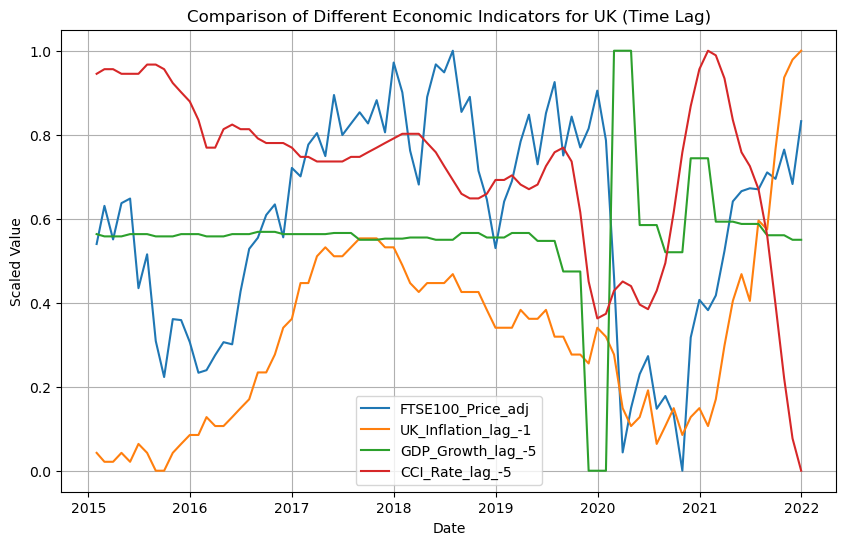

In [11]:
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Select columns to scale
columns_to_scale = ['FTSE100_Price_adj', 'UK_Inflation_lag', 'GDP_Growth_lag', 'CCI_Rate_lag']

# Apply MinMax scaling
df_scaled = df_lagged.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_lagged[columns_to_scale])
df_scaled.dropna(inplace=True)

new_column_names = ['FTSE100_Price_adj', 'UK_Inflation_lag_-1', 'GDP_Growth_lag_-5', 'CCI_Rate_lag_-5']
df_scaled = df_scaled.rename(columns=dict(zip(columns_to_scale, new_column_names)))

# Plotting all the scaled variables
plt.figure(figsize=(10, 6))
for column in new_column_names:
    plt.plot(df_scaled.index, df_scaled[column], label=column)

plt.title('Comparison of Different Economic Indicators for UK (Time Lag)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid()
plt.show()